In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from rdkit import Chem

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

df = pd.read_csv('data/CO2_DB.csv')

df = df[
    ['Energy',
    'Surf_Atom_N',
    'Surf_Atom_M',
    'Surf_Elec_V',
    'Surf_VdW_R',
    'Surf_Cov_R',
    'Surf_Bond_R',
    'Surf_Common_Iso',
    'Surf_Common_Iso_M',
    'DemlData mean atom_num',
    'DemlData mean atom_mass',
    'DemlData mean row_num',
    'DemlData mean col_num',
    'DemlData mean atom_radius',
    'DemlData mean molar_vol',
    'DemlData mean heat_fusion',
    'DemlData mean melting_point',
    'DemlData mean boiling_point',
    'DemlData mean heat_cap',
    'DemlData mean first_ioniz',
    'DemlData mean electronegativity',
    'DemlData mean electric_pol',
    'DemlData mean GGAU_Etot',
    'DemlData mean mus_fere',
    'DemlData mean FERE correction',
    'Reactants_SMARTS',
    'Products_SMARTS'
]
    ]

df.dropna(inplace=True)

df_array = df[[
    'Reactants_SMARTS',
    'Products_SMARTS'
    ]].values


model = word2vec.Word2Vec.load('data/model_300dim.pkl')

#final_data
data_final = []
indices = []
# Sample SMARTS string

for indice, val in enumerate(df_array):
    try:
        val = [string.replace('[*]','') for string in val]

        reactant_smarts = val[0][2:-2].split(',')
        product_smarts = val[1][2:-2].split(',')
        
        #drop '*'
        reactant_smarts = [x.replace("'","").strip() for x in reactant_smarts if x != '[*]']
        product_smarts = [x.replace("'","").strip() for x in product_smarts if x != '[*]']
        
        reactant_smarts = [x for x in reactant_smarts if x != '']
        product_smarts = [x for x in product_smarts if x != '']

        # Convert SMARTS to RDKit molecule object
        reactant_molecule = [Chem.MolFromSmarts(reactant_smarts) for reactant_smarts in reactant_smarts]
        product_molecule = [Chem.MolFromSmarts(product_smarts) for product_smarts in product_smarts]
        
        # Convert RDKit molecule object to SMILES
        reactant_smiles = [Chem.MolToSmiles(reactant_molecule) for reactant_molecule in reactant_molecule]
        product_smiles = [Chem.MolToSmiles(product_molecule) for product_molecule in product_molecule]

        # Convert SMILES to Mol2Vec sentences
        reactant_sentences = [mol2alt_sentence(Chem.MolFromSmiles(smile),  1) for smile in reactant_smiles]
        product_sentences = [mol2alt_sentence(Chem.MolFromSmiles(smile),  1) for smile in product_smiles]

        # Convert Mol2Vec sentences to vectors
        reactant_vectors = [DfVec(x).vec for x in sentences2vec(reactant_sentences, model, unseen='UNK')]
        product_vectors = [DfVec(x).vec for x in sentences2vec(product_sentences, model, unseen='UNK')]

        avg_vectors = ((np.mean(reactant_vectors, axis=0) + np.mean(product_vectors, axis=0)) / 2).flatten()

        data_final.append(avg_vectors)
        indices.append(indice)
    except Exception as e:
        pass


pca_model = PCA(n_components=30)
tsne_model = TSNE(n_components=2, perplexity=10, n_iter=1000, metric = 'cosine')
tsne_pca = tsne_model.fit_transform(pca_model.fit_transform(data_final))

##drop lines from df where mol2vec failed
colunas = df.columns
df_data = df.values[indices]

df = pd.DataFrame(df_data, columns=colunas)

df['tsne-2d-one'] = tsne_pca[:,0]
df['tsne-2d-two'] = tsne_pca[:,1]

df.drop(columns=['Reactants_SMARTS', 'Products_SMARTS'], inplace=True)

## preprocess data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = df.drop('Energy', axis=1)
y = df['Energy']

X = scaler.fit_transform(X)

## train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## train model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error

metrics = {
    'MSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'R^2': r2_score,
    'Explained Variance': explained_variance_score,
    'Max Error': max_error,
    'Median Absolute Error': median_absolute_error
}


## train and evaluete all models
#models = [RandomForestRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor()]
#model_names = ["RandomForest", "GradientBoosting", "AdaBoost", "Bagging", "ExtraTrees"]

models = [GradientBoostingRegressor()]
model_names = ['GradientBoosting']
# Train each model and save the plots
for model, model_name in zip(models, model_names):



    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)

    print(f"Model: {model_name}")
    
    # Evaluate the model with multiple metrics
    for metric_name, metric_func in metrics.items():
        y_pred = model.predict(X_test)
        metric_value = metric_func(y_test, y_pred)
        print(f'{metric_name}: {metric_value:.2f}')


    # Plot predicted vs actual
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    
    # Add a red line
    x = np.linspace(-10, 10, 100)
    plt.plot(x, x, color='red')
    
    # Save the plot with the model name
    plt.savefig(f'{model_name}_plot.png')
    plt.show()




        

[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not r

Model: GradientBoosting
MSE: 0.82
MAE: 0.68
R^2: 0.97
Explained Variance: 0.97
Max Error: 2.82
Median Absolute Error: 0.54


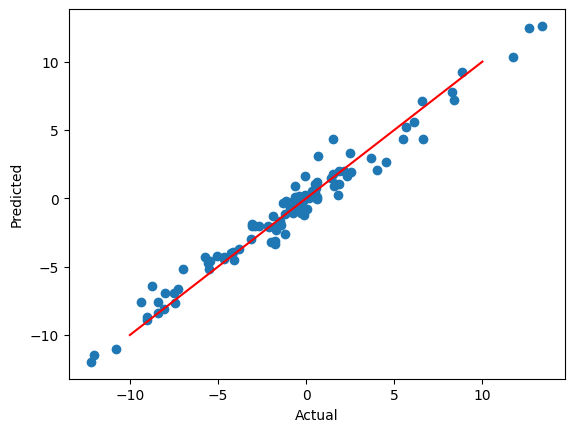

In [32]:
pca_model = PCA(n_components=30)
tsne_model = TSNE(n_components=2, perplexity=10, n_iter=1000, metric = 'cosine')
tsne_pca = tsne_model.fit_transform(pca_model.fit_transform(data_final))

##drop lines from df where mol2vec failed
colunas = df.columns
df_data = df.values[indices]

df = pd.DataFrame(df_data, columns=colunas)

df['tsne-2d-one'] = tsne_pca[:,0]
df['tsne-2d-two'] = tsne_pca[:,1]

df.drop(columns=['Reactants_SMARTS', 'Products_SMARTS'], inplace=True)

## preprocess data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = df.drop('Energy', axis=1)
y = df['Energy']

X = scaler.fit_transform(X)

## train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## train model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error

metrics = {
    'MSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'R^2': r2_score,
    'Explained Variance': explained_variance_score,
    'Max Error': max_error,
    'Median Absolute Error': median_absolute_error
}


## train and evaluete all models
#models = [RandomForestRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor()]
#model_names = ["RandomForest", "GradientBoosting", "AdaBoost", "Bagging", "ExtraTrees"]

models = [GradientBoostingRegressor()]
model_names = ['GradientBoosting']
# Train each model and save the plots
for model, model_name in zip(models, model_names):



    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)

    print(f"Model: {model_name}")
    
    # Evaluate the model with multiple metrics
    for metric_name, metric_func in metrics.items():
        y_pred = model.predict(X_test)
        metric_value = metric_func(y_test, y_pred)
        print(f'{metric_name}: {metric_value:.2f}')


    # Plot predicted vs actual
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    
    # Add a red line
    x = np.linspace(-10, 10, 100)
    plt.plot(x, x, color='red')
    
    # Save the plot with the model name
    plt.savefig(f'{model_name}_plot.png')
    plt.show()


In [27]:
df.columns

Index(['Energy', 'Surf_Atom_N', 'Surf_Atom_M', 'Surf_Elec_V', 'Surf_VdW_R',
       'Surf_Cov_R', 'Surf_Bond_R', 'Surf_Common_Iso', 'Surf_Common_Iso_M',
       'DemlData mean atom_num', 'DemlData mean atom_mass',
       'DemlData mean row_num', 'DemlData mean col_num',
       'DemlData mean atom_radius', 'DemlData mean molar_vol',
       'DemlData mean heat_fusion', 'DemlData mean melting_point',
       'DemlData mean boiling_point', 'DemlData mean heat_cap',
       'DemlData mean first_ioniz', 'DemlData mean electronegativity',
       'DemlData mean electric_pol', 'DemlData mean GGAU_Etot',
       'DemlData mean mus_fere', 'DemlData mean FERE correction'],
      dtype='object')

In [240]:
pca_model = PCA(n_components=30)
tsne_model = TSNE(n_components=2, perplexity=10, n_iter=1000, metric = 'cosine')
tsne_pca = tsne_model.fit_transform(pca_model.fit_transform(data_final))

##drop lines from df where mol2vec failed
colunas = df.columns
df_data = df.values[indices]

df = pd.DataFrame(df_data, columns=colunas)

df['tsne-2d-one'] = tsne_pca[:,0]
df['tsne-2d-two'] = tsne_pca[:,1]

df.drop(columns=['Reactants_SMARTS', 'Products_SMARTS'], inplace=True)

## preprocess data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = df.drop('Energy', axis=1)
y = df['Energy']

X = scaler.fit_transform(X)

## train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## train model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor

## train and evaluete all models
models = [RandomForestRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor()]
for model in models:
    model.fit(X_train, y_train)
    #print(model.score(X_test, y_test))


    ## evaluate model
    from sklearn.metrics import mean_squared_error
    y_pred = model.predict(X_test)
    print('MSE: ', mean_squared_error(y_test, y_pred))

    ## plot predict vs actual
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    ## add line
    x = np.linspace(-10, 10, 100)
    plt.plot(x, x, color='red')
    plt.show()


MSE:  1.4560228040797665


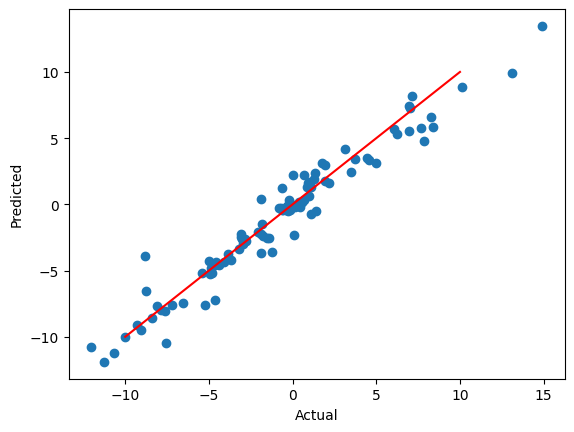

MSE:  0.7741022874699042


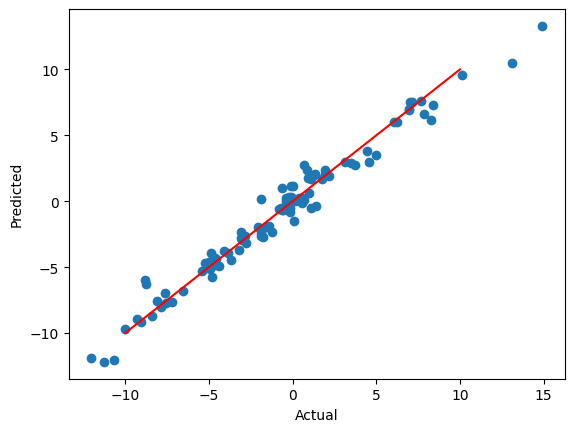

MSE:  3.6853078902498595


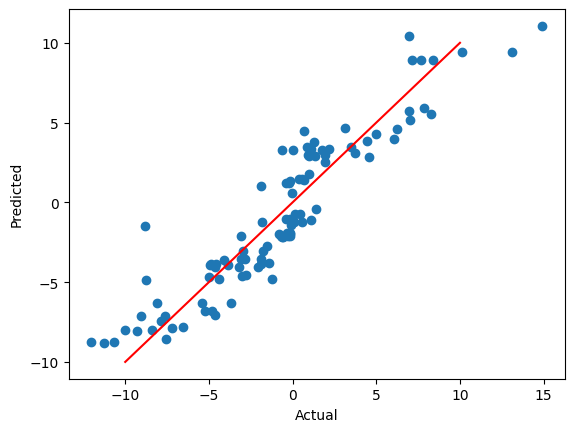

MSE:  1.6623360418456197


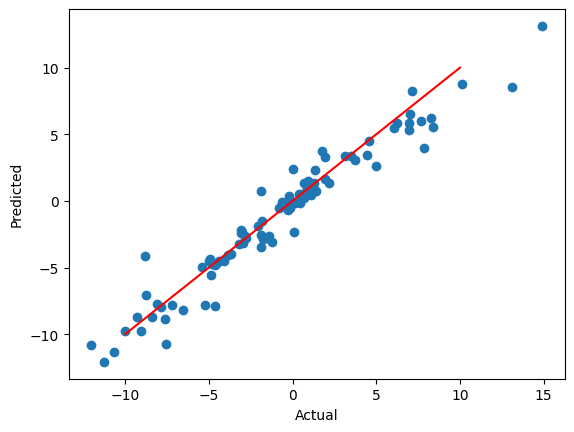

MSE:  1.1188061196874997


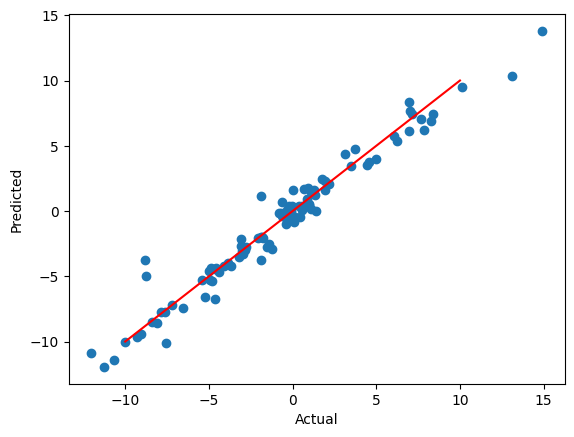

In [243]:
## preprocess data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = df.drop('Energy', axis=1)
y = df['Energy']

X = scaler.fit_transform(X)

## train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## train model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor

## train and evaluete all models
models = [RandomForestRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor()]
for model in models:
    model.fit(X_train, y_train)
    #print(model.score(X_test, y_test))


    ## evaluate model
    from sklearn.metrics import mean_squared_error
    y_pred = model.predict(X_test)
    print('MSE: ', mean_squared_error(y_test, y_pred))

    ## plot predict vs actual
    #plt.scatter(y_test, y_pred)
    #plt.xlabel('Actual')
    plt.ylabel('Predicted')
    ## add line
    x = np.linspace(-10, 10, 100)
    plt.plot(x, x, color='red')
    plt.show()
